In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import pickle 
from scipy.interpolate import UnivariateSpline

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
pi = 3.14159
data = pickle.load( open( "camera_calibration.pkl", "rb" ) )
mtx_camera = data[0]
dist_camera = data[1]

%matplotlib inline

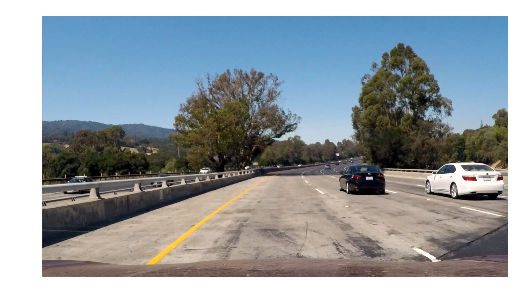

In [2]:
#reading in an image
image = mpimg.imread('test_images/test1.jpg')

plt.imshow(image);  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image
plt.axis('off');

In [3]:
kernel_size = 5

def draw_pw_lines(img,pts,color):
    pts = np.int_(pts)
    for i in range(10):
        x1 = pts[0][i][0]
        y1 = pts[0][i][1]
        x2 = pts[0][i+1][0]
        y2 = pts[0][i+1][1]
        cv2.line(img, (x1, y1), (x2, y2),color,50)
        

def undistort_image(img, mtx, dist):
    undist_img = cv2.undistort(img, mtx, dist, None, mtx)
    return undist_img
def gaussian_blur(img, kernel=5):
    blur = cv2.GaussianBlur(img,(kernel,kernel),0)
    return blur

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    if orient=='x':
        img_s = cv2.Sobel(img,cv2.CV_64F, 1, 0)
    else:
        img_s = cv2.Sobel(img,cv2.CV_64F, 0, 1)
    img_abs = np.absolute(img_s)
    img_sobel = np.uint8(255*img_abs/np.max(img_abs))
    
    binary_output = 0*img_sobel
    binary_output[(img_sobel >= thresh[0]) & (img_sobel <= thresh[1])] = 1
    return binary_output

def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    img_sx = cv2.Sobel(img,cv2.CV_64F, 1, 0)
    img_sy = cv2.Sobel(img,cv2.CV_64F, 0, 1)
    
    img_s = np.sqrt(img_sx**2 + img_sy**2)
    img_s = np.uint8(img_s*255/np.max(img_s))
    binary_output = 0*img_s
    binary_output[(img_s>=thresh[0]) & (img_s<=thresh[1]) ]=1
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    img_sx = cv2.Sobel(img,cv2.CV_64F,1,0, ksize=sobel_kernel)
    img_sy = cv2.Sobel(img,cv2.CV_64F,0,1, ksize=sobel_kernel)
    
    grad_s = np.arctan2(np.absolute(img_sy), np.absolute(img_sx))
    
    binary_output = 0*grad_s # Remove this line
    binary_output[(grad_s>=thresh[0]) & (grad_s<=thresh[1])] = 1
    return binary_output
    
def GaussianC_Adaptive_Threshold(img,kernel,cut_val):

    img_cut = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,kernel,cut_val)
    return img_cut

def warp_image(img,src,dst,img_size):
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    Minv = cv2.getPerspectiveTransform(dst, src)

    return warped,M,Minv

def sobel_combined(image):
    img_g_mag = mag_thresh(image,3,(20,150))
    img_d_mag = dir_threshold(image,3,(.6,1.1))
    img_abs_x = abs_sobel_thresh(image,'x',5,(50,200))
    img_abs_y = abs_sobel_thresh(image,'y',5,(50,200))
    sobel_combined = np.zeros_like(img_d_mag)
    sobel_combined[((img_abs_x == 1) & (img_abs_y == 1)) | \
               ((img_g_mag == 1) & (img_d_mag == 1))] = 1
    return sobel_combined


def color_mask(hsv,low,high):
    mask = cv2.inRange(hsv, low, high)
    return mask

def apply_color_mask(hsv,img,low,high):
    mask = cv2.inRange(hsv, low, high)
    res = cv2.bitwise_and(img,img, mask= mask)
    return res

def moving_average(a, n=3):
    # Moving average
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n


In [4]:
def pipeline_process(image):
    image = undistort_image(image, mtx_camera , dist_camera )
    image = gaussian_blur(image, kernel=5)
    img_size = np.shape(image)
    
    
    img_gs = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    sobel_c = sobel_combined(img_gs)
    return image
    

In [5]:
image_ud = undistort_image(image, mtx_camera , dist_camera )

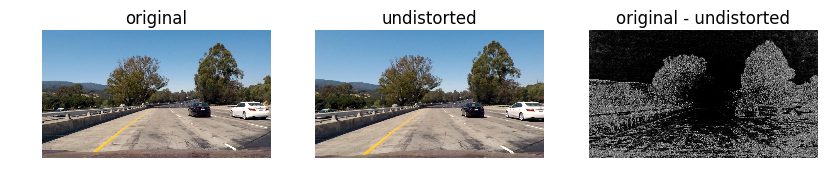

In [6]:
plt.figure(figsize=(10,2))
plt.subplot(1,3,1)
plt.imshow(image)
plt.axis('off');
plt.title('original')
plt.subplot(1,3,2)
plt.imshow(image_ud)
plt.title('undistorted')
plt.axis('off');
plt.subplot(1,3,3)
plt.imshow(np.sum((image-image_ud)**2,axis=2),cmap='gray')
plt.title('original - undistorted')
plt.axis('off');

In [7]:
#cv2.imshow('image',image_ud)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

In [8]:
image = image_ud

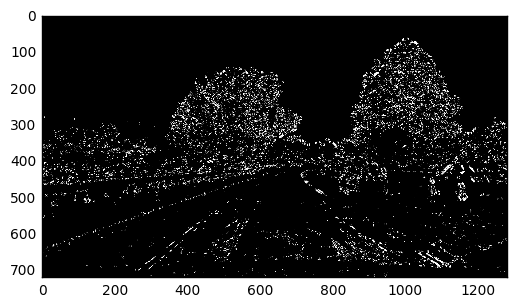

In [9]:
image = gaussian_blur(image, kernel=5)
img_gs = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
sobel_c = sobel_combined(img_gs)
plt.imshow(sobel_c,cmap='gray')

In [10]:
img_size = np.shape(image)

In [11]:
ht_window = np.uint(img_size[0]/1.5)
hb_window = np.uint(img_size[0])
c_window = np.uint(img_size[1]/2)
ctl_window = c_window - .2*np.uint(img_size[1]/2)
ctr_window = c_window + .2*np.uint(img_size[1]/2)
cbl_window = c_window - 1*np.uint(img_size[1]/2)
cbr_window = c_window + 1*np.uint(img_size[1]/2)


In [12]:
src = np.float32([[cbl_window,hb_window],[cbr_window,hb_window],[ctr_window,ht_window],[ctl_window,ht_window]])

dst = np.float32([[0,img_size[0]],[img_size[1],img_size[0]],
                  [img_size[1],0],[0,0]])

warped,M_warp,Minv_warp = warp_image(image,src,dst,(img_size[1],img_size[0]))

In [13]:
image.shape

(720, 1280, 3)

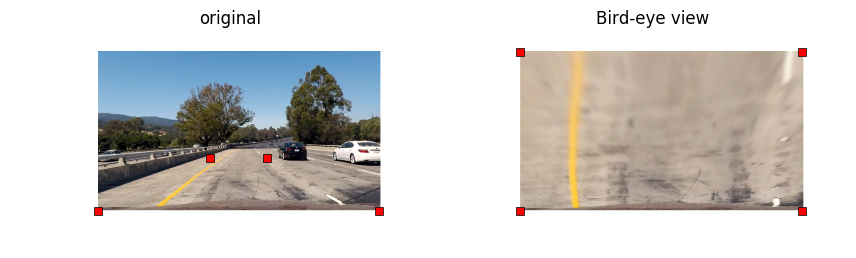

In [14]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(image,cmap='gray')
for i in range(4):
    plt.plot(src[i][0],src[i][1],'rs')
plt.title('original')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(warped,cmap='gray')
for i in range(4):
    plt.plot(dst[i][0],dst[i][1],'rs')
    
plt.title('Bird-eye view')
plt.axis('off');

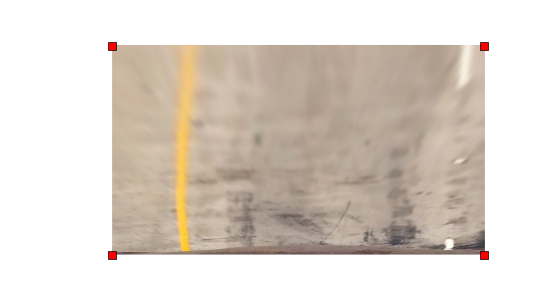

In [15]:
plt.imshow(warped,cmap='gray')
for i in range(4):
    plt.plot(dst[i][0],dst[i][1],'rs')
plt.axis('off');


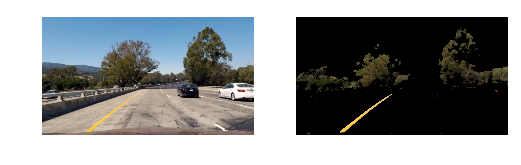

In [16]:
image_HSV = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)

yellow_hsv_low  = np.array([ 0, 80, 0])
yellow_hsv_high = np.array([ 80, 255, 255])


res_mask = color_mask(image_HSV,yellow_hsv_low,yellow_hsv_high)

res = apply_color_mask(image_HSV,image,yellow_hsv_low,yellow_hsv_high)

plt.subplot(1,2,1)
plt.imshow(image)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(res)
plt.axis('off');

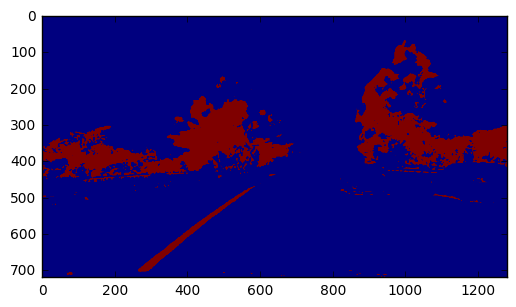

In [17]:
plt.imshow(res_mask)

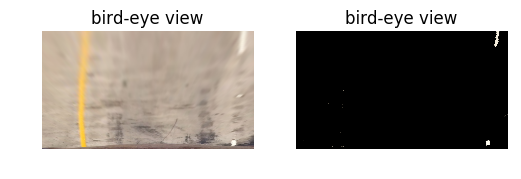

In [18]:
image_HSV = cv2.cvtColor(warped,cv2.COLOR_RGB2HSV)


white_hsv_low  = np.array([  20,   0,   180])
white_hsv_high = np.array([ 255,  80, 255])

res1 = apply_color_mask(image_HSV,warped,white_hsv_low,white_hsv_high)

plt.subplot(1,2,1)
plt.imshow(warped)
plt.title('bird-eye view')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(res1)
plt.title('bird-eye view')
plt.axis('off');


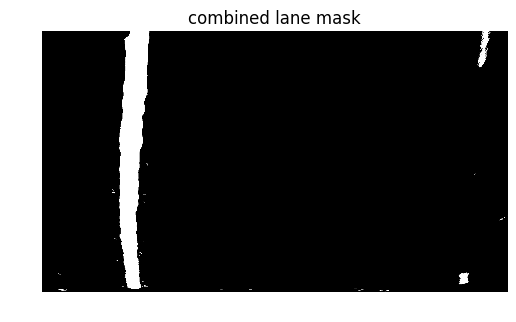

In [19]:
mask_yellow = color_mask(image_HSV,yellow_hsv_low,yellow_hsv_high)
mask_white = color_mask(image_HSV,white_hsv_low,white_hsv_high)
mask_lane = cv2.bitwise_or(mask_yellow,mask_white)
plt.imshow(mask_lane,cmap='gray')
plt.title('combined lane mask')
plt.axis('off');

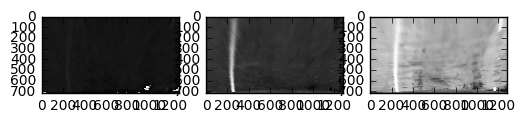

In [20]:
plt.subplot(1,3,1)
plt.imshow(image_HSV[:,:,0],cmap='gray')
plt.subplot(1,3,2)
plt.imshow(image_HSV[:,:,1],cmap='gray')
plt.subplot(1,3,3)
plt.imshow(image_HSV[:,:,2],cmap='gray')

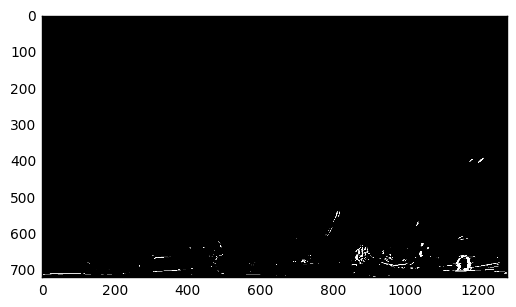

In [21]:
image = gaussian_blur(warped, kernel=5)
image_HLS = cv2.cvtColor(warped,cv2.COLOR_RGB2HLS)

img_gs = image_HLS[:,:,1]
#img_gs = cv2.cvtColor(warped,cv2.COLOR_RGB2GRAY)
sobel_c = sobel_combined(img_gs)
#img_d_mag = dir_threshold(img_gs,3,(.6,1.1))
#img_m_mag = mag_thresh(img_gs,5,(20,265))
img_abs_x = abs_sobel_thresh(img_gs,'x',5,(50,225))
img_abs_y = abs_sobel_thresh(img_gs,'y',5,(50,225))
plt.imshow(cv2.bitwise_or(img_abs_x,img_abs_y),cmap='gray')

wraped2 = np.copy(cv2.bitwise_or(img_abs_x,img_abs_y))

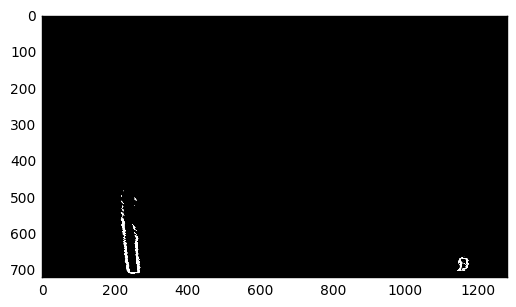

In [22]:
img_gs = image_HLS[:,:,2]
#img_gs = cv2.cvtColor(warped,cv2.COLOR_RGB2GRAY)
sobel_c = sobel_combined(img_gs)
#img_d_mag = dir_threshold(img_gs,3,(.6,1.1))
#img_m_mag = mag_thresh(img_gs,5,(20,265))
img_abs_x = abs_sobel_thresh(img_gs,'x',5,(50,255))
img_abs_y = abs_sobel_thresh(img_gs,'y',5,(50,255))
plt.imshow(cv2.bitwise_or(img_abs_x,img_abs_y),cmap='gray')

wraped3 = np.copy(cv2.bitwise_or(img_abs_x,img_abs_y))

In [23]:
wraped3 = np.copy(cv2.bitwise_or(img_abs_x,img_abs_y))

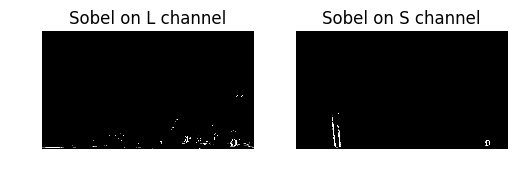

In [24]:

plt.subplot(1,2,1)
plt.imshow(wraped2,cmap='gray')
plt.title('Sobel on L channel')
plt.axis('off')
plt.subplot(1,2,2)
plt.title('Sobel on S channel')
plt.imshow(wraped3,cmap='gray')
plt.axis('off');

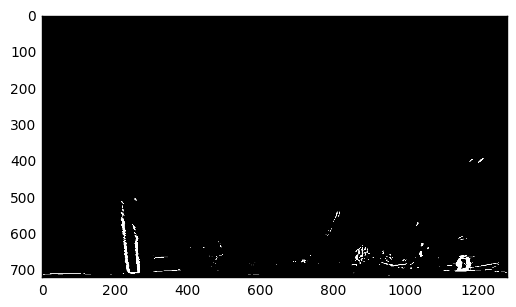

In [25]:
image_cmb = cv2.bitwise_or(wraped2,wraped3)
image_cmb = gaussian_blur(image_cmb,3)
plt.imshow(image_cmb,cmap='gray')

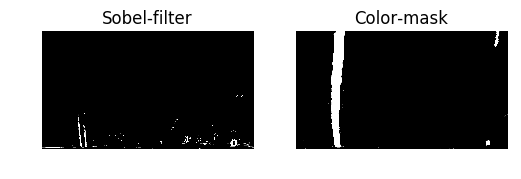

In [26]:
image_cmb = cv2.bitwise_or(wraped2,wraped3)
#image_cmb = cv2.bitwise_or(image_cmb,res)
#image_cmb = gaussian_blur(image_cmb,3)

image_cmb1 = np.zeros_like(image_cmb)
image_cmb1[(mask_lane>=.5)|(image_cmb>=.5)]=1


plt.subplot(1,2,1)
plt.imshow(image_cmb,cmap='gray')
plt.axis('off')
plt.title('Sobel-filter')
plt.subplot(1,2,2)
plt.imshow(mask_lane,cmap='gray')
plt.axis('off')
plt.title('Color-mask')


(-0.5, 1279.5, 719.5, -0.5)

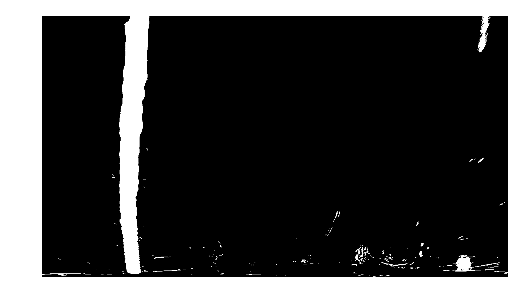

In [27]:
plt.imshow(gaussian_blur(image_cmb1,1),cmap='gray')
plt.axis('off')

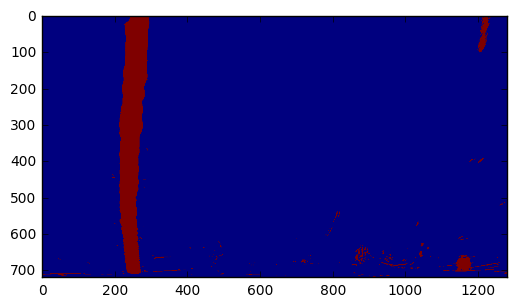

In [28]:
plt.imshow(image_cmb1)


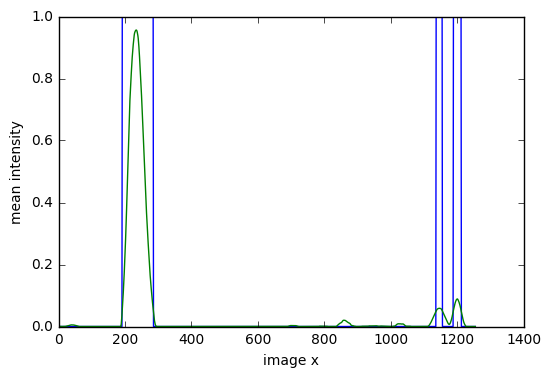

In [29]:
image_cmb1 = gaussian_blur(image_cmb1,11)
mov_filtsize = img_size[1]/50.
mean_lane = np.mean(image_cmb1,axis=0)
mean_lane = moving_average(mean_lane,mov_filtsize)
plt.plot(mean_lane>.05)
plt.plot(mean_lane)
plt.xlabel('image x')
plt.ylabel('mean intensity')


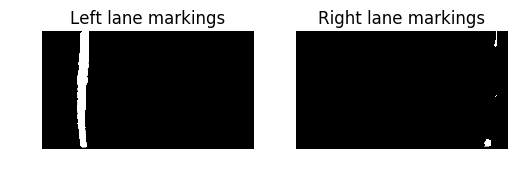

In [30]:
arg_fsb = np.argwhere(mean_lane>.05)
arg_fsb_L = arg_fsb[arg_fsb<img_size[1]/2.]
arg_fsb_L_min = np.min(arg_fsb_L)
arg_fsb_L_max = np.max(arg_fsb_L)

img_L = np.copy(image_cmb1)
img_L[:,0:arg_fsb_L_min] = 0
img_L[:,arg_fsb_L_max:img_size[1]] = 0


arg_fsb_R = arg_fsb[arg_fsb>img_size[1]/2.]
arg_fsb_R_min = np.min(arg_fsb_R)
arg_fsb_R_max = np.max(arg_fsb_R)

img_R = np.copy(image_cmb1)
img_R[:,0:arg_fsb_R_min] = 0
img_R[:,arg_fsb_R_max:img_size[1]] = 0
#img_L = gaussian_blur(img_L,5)



plt.subplot(1,2,1)
plt.imshow(img_L,cmap='gray')
plt.axis('off')
plt.title('Left lane markings')
plt.subplot(1,2,2)
plt.imshow(img_R,cmap='gray')
plt.axis('off')
plt.title('Right lane markings');

    

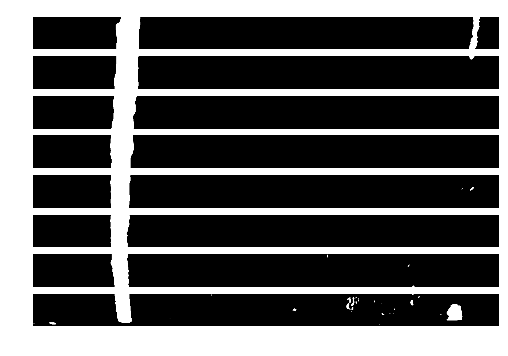

In [31]:
for i in range(8):
    img_y1 = img_size[0]-img_size[0]*i/8
    img_y2 = img_size[0]-img_size[0]*(i+1)/8
    plt.subplot(8,1,8-i)
    plt.imshow(image_cmb1[img_y2:img_y1,:],cmap='gray')
    plt.axis('off')


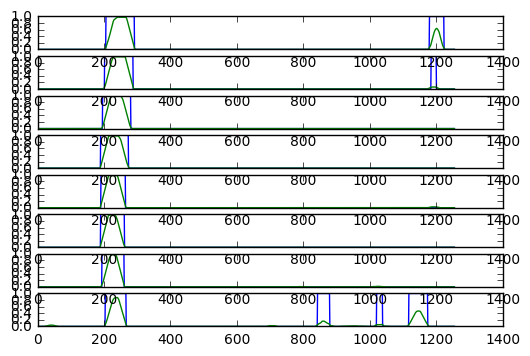

In [32]:
for i in range(8):
    img_y1 = img_size[0]-img_size[0]*i/8
    img_y2 = img_size[0]-img_size[0]*(i+1)/8
    mean_lane = np.mean(image_cmb1[img_y2:img_y1,:],axis=0)
    mean_lane = moving_average(mean_lane,mov_filtsize)
    
    arg_fsb = np.argwhere(mean_lane>.1)
    
    plt.subplot(8,1,8-i)
    plt.plot(mean_lane>.05)
    plt.plot(mean_lane)

In [33]:
1280-1256


24

(-200.0, 1400.0, 800.0, -100.0)

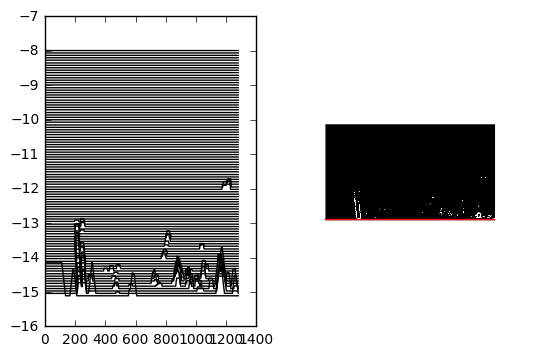

In [34]:
mov_filtsize = img_size[1]/50.


#plt.figure(figsize=(5,5))
plt.subplot(1,2,1)
for i in range(100):
    n_pl = np.int(img_size[0]/100*i)-1
    plt.plot(np.linspace(0,img_size[1],img_size[1]-24),-8+moving_average(image_cmb[n_pl],mov_filtsize)+-n_pl/100,'k');
plt.subplot(1,2,2)
plt.imshow(image_cmb,cmap='gray')
plt.plot([0,1280],[n_pl,n_pl],'r')
plt.axis('off')

In [35]:
image_cmb[0]

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

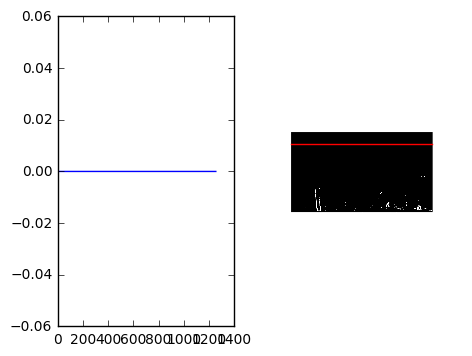

In [36]:
ind_x = 100
plt.figure(figsize=(5,4))
plt.subplot(1,2,1)
plt.plot(moving_average(image_cmb[ind_x],mov_filtsize));
plt.subplot(1,2,2)
plt.imshow(image_cmb,cmap='gray')
plt.axis('off')
plt.plot([0,1280],[ind_x,ind_x],'r')

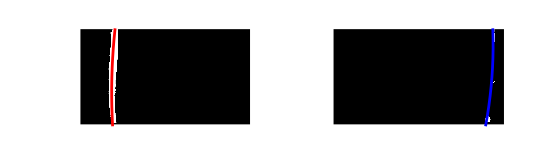

In [37]:
vals = np.argwhere(img_L>.5)
all_x = vals.T[0]
all_y =vals.T[1]

left_fit = np.polyfit(all_x, all_y, 2)
left_y = np.arange(11)*img_size[0]/10
left_fitx = left_fit[0]*left_y**2 + left_fit[1]*left_y + left_fit[2]



# Plot up the fake data
plt.subplot(1,2,1)
plt.imshow(img_L,cmap='gray')
plt.plot( left_fitx,left_y,'red',linewidth=2)
plt.axis('off');

vals = np.argwhere(img_R>.5)
all_x = vals.T[0]
all_y =vals.T[1]

right_fit = np.polyfit(all_x, all_y, 2)
right_y = np.arange(11)*img_size[0]/10
right_fitx = right_fit[0]*right_y**2 + right_fit[1]*right_y + right_fit[2]



# Plot up the fake data
plt.subplot(1,2,2)
plt.imshow(img_R,cmap='gray')
plt.plot( right_fitx,right_y,'b',linewidth=2)
plt.axis('off');


In [38]:
warp_zero = np.zeros_like(image_cmb1).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, left_y]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, right_y])))])
pts = np.hstack((pts_left, pts_right))


cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 255))

col_L = (255,255,0)
col_R = (255,255,255)    

draw_pw_lines(color_warp,np.int_(pts_left),col_L)
draw_pw_lines(color_warp,np.int_(pts_right),col_R)


newwarp = cv2.warpPerspective(color_warp, Minv_warp, (image.shape[1], image.shape[0])) 


result = cv2.addWeighted(image_ud, 1, newwarp, 0.5, 0)

(-0.5, 1279.5, 719.5, -0.5)

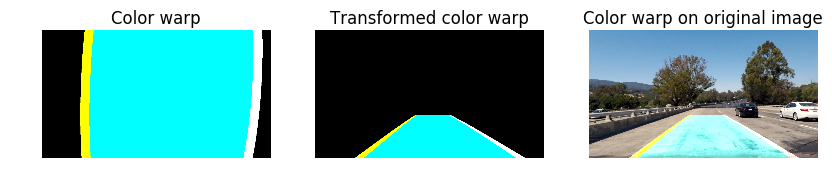

In [39]:
plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.imshow(color_warp)
plt.axis('off')
plt.title('Color warp')
plt.subplot(1,3,2)
plt.imshow(newwarp)
plt.title('Transformed color warp')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(result)
plt.title('Color warp on original image')
plt.axis('off')